# ECE 157A/272A Fall 2022 Homework 2

Name: Jackson Newman

In [1]:
import os
import typing
from typing import Tuple

import numpy as np
import pandas as pd

# OpenCV and Scikit-Image for image manipulation 
import cv2
from skimage.transform import resize
from skimage.measure import label, regionprops, perimeter
from skimage.morphology import binary_erosion,square
import math

# Seaborn and Matplotlib for plotting
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-Learn Descision Tree and helper functions
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, homogeneity_score, completeness_score

FAIL = 2 # failing die
PASS = 1 # passing die
NO_DIE = 0 # no die
RANDOM_SEED = 10

### Helper Functions

In [2]:
def output_image(wafer_map: np.ndarray, name: str, dir: str, vmin: int=0, vmax: int=2) -> None:
    if not os.path.isdir(dir):
        os.mkdir(dir)
    # use plt.imsave to save wafer_map under the given directory with the given name
    os.chdir(dir)
    plt.imsave(name, wafer_map, format='png', vmin=0, vmax=2)
    os.chdir('..')
    
    return

def output_all_wafer_maps(df: pd.DataFrame) -> None:
    # From the row, get wafer map, failure type, lot name and wafer index
    # output wafer map as "<failure type dir>/<lot name>-<wafer index>.png"
    for index, row in df.iterrows():
        waferMap = row["waferMap"]
        failureType = row["failureType"]
        name = row["lotName"]
        waferIndex = row["waferIndex"]
        output_image(waferMap, name+'-'+str(waferIndex), failureType)

    return


In [3]:
def visualize_failure_types(df: pd.DataFrame, figsize=(16,9)) -> None:
    # Find unique failure types within the "failureType" column of the df
    failTypes = []
    for index, row in df.iterrows():
        if failTypes.count(row["failureType"]) == 0:
            failTypes.append(row["failureType"])
    # Create plt canvas with 6 subplots (2 rows and 3 columns) with plt.subplots
    plt.figure(figsize=(16, 9))
    # iterate through all the classes and show one wafer map per class
    for i in range(1,6):
        for index, row in df.iterrows():
            failureType = row["failureType"]
            name = row["lotName"]
            waferIndex = row["waferIndex"]
            plt.subplot(2,3,i)
            # Plt image on the axes
            if failureType == failTypes[i-1]:
                plt.imshow(row["waferMap"])
                break;
    
    plt.show()


### Load Dataset

In [4]:
# load training dataset as pandas dataframe
np_train = np.load('wafermap_train.npy', allow_pickle=True)
df_train = pd.DataFrame.from_records(np_train)


### Dataset Inspection

In [5]:
# use pandas to inspect the dataset information
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1693 entries, 0 to 1692
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   index           1693 non-null   int64  
 1   dieSize         1693 non-null   float64
 2   failureType     1693 non-null   object 
 3   lotName         1693 non-null   object 
 4   trainTestLabel  1693 non-null   object 
 5   waferIndex      1693 non-null   float64
 6   waferMap        1693 non-null   object 
dtypes: float64(2), int64(1), object(4)
memory usage: 92.7+ KB


In [6]:
# inspect the dieSize
df_train['dieSize'].value_counts()

1334.0    297
1226.0    145
2393.0     99
1080.0     77
1389.0     68
         ... 
2071.0      1
7870.0      1
4014.0      1
2268.0      1
1791.0      1
Name: dieSize, Length: 205, dtype: int64

<AxesSubplot: >

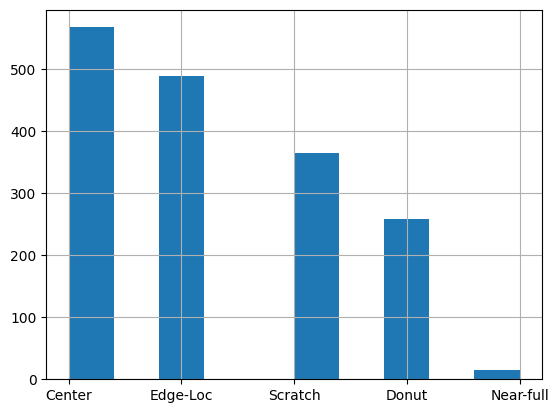

In [7]:
# inspect the failure types and the distributions
df_train['failureType'].hist()

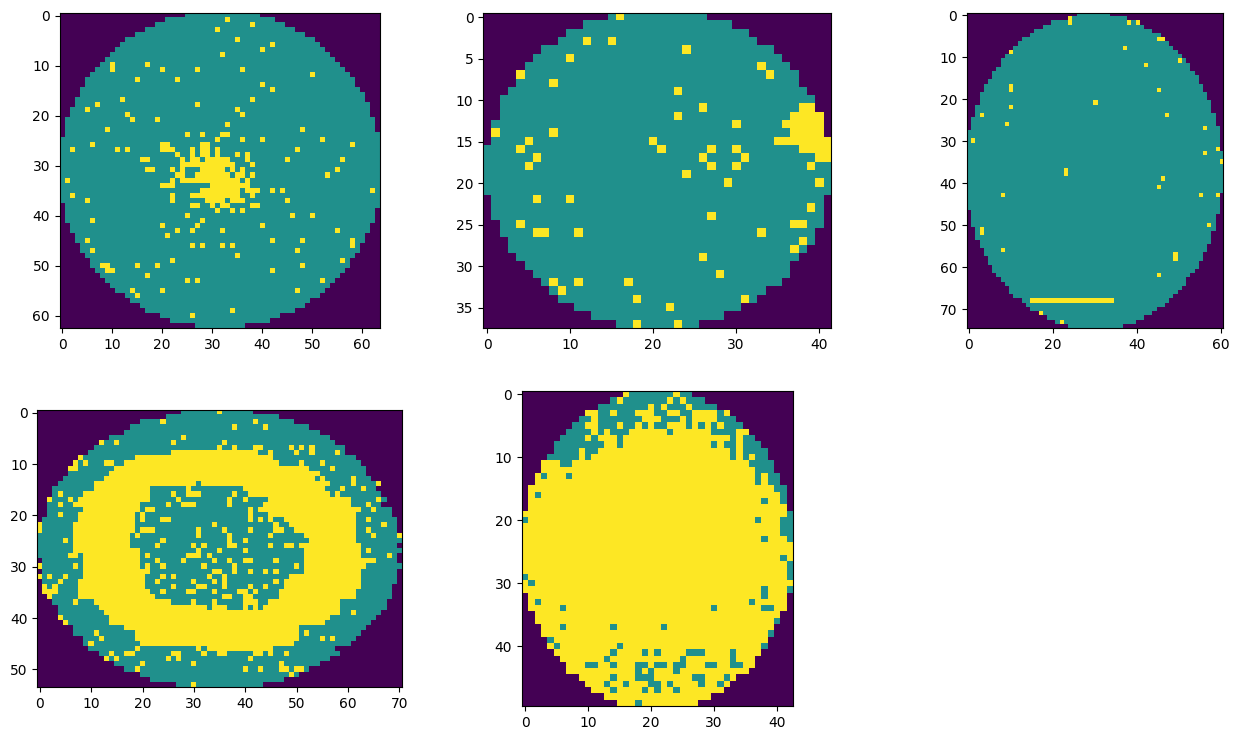

In [8]:
# show a wafermap in each class
visualize_failure_types(df_train)

In [9]:
# output all images to failure type directory
root_dir = 'defect_types'
output_all_wafer_maps(df_train)

### Data Preparation (Part 1)

For data preparation, we need to perform the following operations:
1) Resize the wafer maps as a numpy array of shape [x, 64, 64]
2) Convert the labels into numeric values

In [10]:
# The function takes the failure type string 
# and returns the numeric value of failureType
def convert_failure_type(failure_type: str) -> int:
    # Create dictionary for converting string to numeric number
    string2int = {
        "Center" : 1,
        "Edge-Loc" : 2,
        "Scratch" : 3,
        "Donut" : 4,
        "Near-full" : 5
    }

    return string2int[failure_type]

# The function resizes a wafer to specified output shape using opencv's resize function
def resize_wafer_map(wafer_map: np.ndarray, output_shape: tuple=(64, 64)) -> np.ndarray:

    resized_wafer_map = cv2.resize(wafer_map,output_shape)
    
    return resized_wafer_map

# create dataframe columns to store the return values of the two tasks below:
#       (1) reshapes the wafer maps as a numpy array of shape (64, 64), 
#       (2) and converts the failureType into numeric values 
def prepare_data(df: pd.DataFrame, has_labels: bool=True) -> Tuple[np.ndarray, list]:
    # Resize_wafer_map function to resize the wafer map to a larger size
    df['waferMap'] = df['waferMap'].apply(resize_wafer_map) 
    if(has_labels):
        df['failureTypeInt'] = df['failureType'].apply(convert_failure_type)

    return df

Prepare the data with the above function

In [11]:
# actually resizing the wafer map and converting failure types
# in the training dataframe
df_train = prepare_data(df_train)

### Feature Engineering
Extract features from the wafer maps

In [16]:
# The function that detects connect components using skimage
# and selects one with the largest area which we call salient region
def get_salient_region(row: pd.Series) -> np.ndarray:
    # get wafer map from dataframe row
    wafer_map = row['waferMap']

    # create a wafer map with NO_DIE as background and FAIL as defect
    failure_only = np.zeros_like(wafer_map)
    failure_only[wafer_map==FAIL] = FAIL

    # label the connected components and get their regions properties
    labeled_image = label(failure_only, background=NO_DIE, connectivity=2)
    region_props = regionprops(labeled_image)

    # returns the largest connected component as salient region
    largest_region_label = np.argmax([prop.area for prop in region_props]) + 1
    salient_region = np.zeros_like(labeled_image)
    salient_region[labeled_image == largest_region_label] = FAIL

    return salient_region

# The function returns the ratio of the area of the salient region to the area of the wafer map
def get_area_ratio(row: pd.Series) -> float:
    # retrieve wafer map and salient region from dataframe row
    wafer_map = row["waferMap"]
    salient_region = get_salient_region(row)
    # count the number of fail dice on salient region
    # count the total number of dice on wafer map
    # divide them to get area_ratio
    waferArea = np.sum(wafer_map != 0)
    salientArea = np.sum(salient_region == 1)
    area_ratio = salientArea/waferArea
    return area_ratio

# The function returns the ratio of the perimeter of the salient region to the radius of the wafer map
def get_perimeter_ratio(row: pd.Series) -> float:
    # retrieve wafer map and salient region from dataframe row
    wafer_map = row["waferMap"]
    salient_region = get_salient_region(row)
    # label the salient region connected components and get their regions properties
    labelSalient = label(salient_region)
    salientRegions = regionprops(labelSalient)
    # find perimeter and wafer map radius
    perimeter = salientRegions[0].perimeter
    waferMapRadius = 32
    # divide them to get ratio
    perimeter_ratio = perimeter/waferMapRadius
    return perimeter_ratio

# The function returns the maximal distance between the salient region and 
# the center of the wafer map
def get_max_dist_from_center(row: pd.Series) -> float:
    # retrieve wafer map and salient region from dataframe row
    wafer_map = row["waferMap"]
    salient_region = get_salient_region(row)
    # find center of the wafer map
    labelWafer = label(wafer_map)
    waferRegions = regionprops(labelWafer)
    waferCenter = waferRegions[0].centroid
    
    # get all coordinates of the salient region and compute the max distance
    # from center
    labelSalient = label(salient_region)
    salientRegions = regionprops(labelSalient)

    salientCoordinates = salientRegions[0].coords
    
    max_distance = 0
    for coordinates in salientCoordinates:
        distance = math.sqrt((32 - coordinates[0])**2 + (32 - coordinates[1])**2)
        if distance > max_distance:
            max_distance = distance

    return max_distance

# The function returns the minimal distance between the salient region and 
# the center of the wafer map
def get_min_dist_from_center(row: pd.Series) -> float:
    # retrieve wafer map and salient region from dataframe row
    wafer_map = row["waferMap"]
    salient_region = get_salient_region(row)
    # find center of the wafer map
    wafer_map = row["waferMap"]
    salient_region = get_salient_region(row)
    # find center of the wafer map
    labelWafer = label(wafer_map)
    waferRegions = regionprops(labelWafer)
    labelSalient = label(salient_region)
    salientRegions = regionprops(labelSalient)

    waferCenter = waferRegions[0].centroid
    salientCoordinates = salientRegions[0].coords

    # get all coordinates of the salient region and compute the min distance
    # from center
    min_distance = 64
    for coordinates in salientCoordinates:
        distance = math.sqrt(
            (32 - coordinates[0])**2 + (32 - coordinates[1])**2)
        if distance < min_distance:
            min_distance = distance

    return min_distance

# The function returns the ratio of the length of the major axis of the estimated 
# ellipse surrounding the salient region to the radius of the wafer map
def get_major_axis_ratio(row: pd.Series) -> float:
    # retrieve wafer map and salient region from dataframe row
    wafer_map = row["waferMap"]
    salient_region = get_salient_region(row)
    # label the salient region connected components and get their regions properties
    labelWafer = label(wafer_map)
    waferRegions = regionprops(labelWafer)
    labelSalient = label(salient_region)
    salientRegions = regionprops(labelSalient)
    
    waferRadius = 32
    salientMajorAxis = salientRegions[0].major_axis_length

    # find major axis and wafer map radius
    major_axis_ratio = salientMajorAxis/waferRadius
    
    return major_axis_ratio

# The function returns the ratio of the length of the minor axis of the estimated 
# ellipse surrounding the salient region to the radius of the wafer map
def get_minor_axis_ratio(row: pd.Series) -> float:
    # retrieve wafer map and salient region from dataframe row
    wafer_map = row["waferMap"]
    salient_region = get_salient_region(row)
    # label the salient region connected components and get their regions properties
    labelWafer = label(wafer_map)
    waferRegions = regionprops(labelWafer)
    labelSalient = label(salient_region)
    salientRegions = regionprops(labelSalient)

    waferRadius = 32
    salientMinorAxis = salientRegions[0].minor_axis_length

    # find minor axis and wafer map radius
    minor_axis_ratio = salientMinorAxis/waferRadius

    return minor_axis_ratio

# The function returns the solidity, indicating the proportion of defective dice
# in the estimated convex hull of the salient region
def get_solidity(row: pd.Series) -> float:
    # retrieve wafer map and salient region from dataframe row
    wafer_map = row["waferMap"]
    salient_region = get_salient_region(row)
    # label the salient region connected components and get their regions properties
    labelSalient = label(salient_region)
    salientRegions = regionprops(labelSalient)
    # get solidity of salient region
    solidity = salientRegions[0].solidity

    return solidity

# The function returns the eccentricity of the salient region
def get_eccentricity(row: pd.Series) -> float:
    # retrieve wafer map and salient region from dataframe row
    wafer_map = row["waferMap"]
    salient_region = get_salient_region(row)
    # label the salient region connected components and get their regions properties
    labelSalient = label(salient_region)
    salientRegions = regionprops(labelSalient)
    # get eccentricity of salient region
    eccentricity = salientRegions[0].eccentricity
    
    return eccentricity

# The function returns the ratio of the failed dice on the wafer map to the total
# number of dice on the wafer map
def get_yield_loss(row: pd.Series) -> float:
    # retrieve wafer map
    wafer_map = row["waferMap"]
    # count FAIL dice and total number of dice
    fails = np.sum(wafer_map == 2)
    waferArea = np.sum(wafer_map != 0)

    # compute yield loss
    yield_loss = fails/waferArea

    return yield_loss

# The function returns the ratio of the failed dice on the outermost two rings of the
# wafer map to the total number of dice on the outermost two rings of the wafer map
def get_edge_yield_loss(row: pd.Series) -> float:
    # retrieve wafer map
    wafer_map = row["waferMap"]
    # find ring label that highlights the outermost two rings of the wafer
    rings = ring_label_from_outside(wafer_map)
    rings = np.logical_not(rings)
    twoOutermostRings = np.logical_and(wafer_map, rings)
    # get edge FAIL dice and total number of edge dice
    binary_map = (wafer_map == FAIL)
    failsInRings = np.logical_and(binary_map, twoOutermostRings)
    fails=np.sum(failsInRings==1)
    total=np.sum(twoOutermostRings==1)
    edge_yield_loss = fails/total

    return edge_yield_loss

# This helper function returns return an numpy array highlighting the outermost two rings
# of the wafer map with nonzero value
def ring_label_from_outside(wafer_map: np.ndarray) -> np.ndarray:
    binary_map = (wafer_map != NO_DIE)
    
    ring_labels = binary_erosion(binary_map, footprint=square(5))
    ring_labels[:, :2] = NO_DIE
    ring_labels[:2, :] = NO_DIE
    ring_labels[62:64, :] = NO_DIE
    ring_labels[:, 62:64] = NO_DIE
    
    return ring_labels

In [17]:
failure_type = 'Center'
row_index = 0
row = df_train.loc[df_train['failureType']==failure_type].iloc[row_index]

print(get_salient_region(row))
print(get_area_ratio(row))
print(get_max_dist_from_center(row))
print(get_min_dist_from_center(row))
print(get_perimeter_ratio(row))
print(get_major_axis_ratio(row))
print(get_minor_axis_ratio(row))
print(get_solidity(row))
print(get_eccentricity(row))
print(get_yield_loss(row))
print(get_edge_yield_loss(row))


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
0.0
7.211102550927978
0.0
1.3428300858899105
0.4097988508847298
0.2500520394218446
0.6881720430107527
0.7922609793257968
0.04744413835322926
0.034274193548387094


In [18]:
# This function applies all feature extractor functions onto the 
# dataframe and save the results to new columns
def create_feature_columns(df: pd.DataFrame) -> pd.DataFrame:
    # format df['<new column name>'] = df.apply(<feature extractor function>, axis=1)
    df['salientRegion'] = df.apply(get_salient_region, axis=1)
    df['areaRatio'] = df.apply(get_area_ratio, axis=1)
    df['maxDistFromCenter'] = df.apply(get_max_dist_from_center, axis=1)
    df['minDistFromCenter'] = df.apply(get_min_dist_from_center, axis=1)
    df['perimeterRatio'] = df.apply(get_perimeter_ratio, axis=1)
    df['majorAxisRatio'] = df.apply(get_major_axis_ratio, axis=1)
    df['minorAxisRatio'] = df.apply(get_minor_axis_ratio, axis=1)
    df['solidity'] = df.apply(get_solidity, axis=1)
    df['eccentricity'] = df.apply(get_eccentricity, axis=1)
    df['yieldLoss'] = df.apply(get_yield_loss, axis=1)
    df['edgeYieldLoss'] = df.apply(get_edge_yield_loss, axis=1)

    return df

In [19]:
# actually applying the feature extractors on the training dataframe
df_train = create_feature_columns(df_train)

### Data Preparation (Part 2)

prepare the dataset for training models

In [20]:
selected_features = ['areaRatio',
                     'maxDistFromCenter', 'minDistFromCenter', 'perimeterRatio', 
                     'majorAxisRatio', 'minorAxisRatio', 'solidity', 'eccentricity',
                     'yieldLoss', 'edgeYieldLoss']
x = df_train[selected_features]
y = df_train['failureTypeInt']
test_ratio = 0.2
x_train,x_valid,y_train,y_valid = train_test_split(x,y,test_size=test_ratio,random_state=RANDOM_SEED)

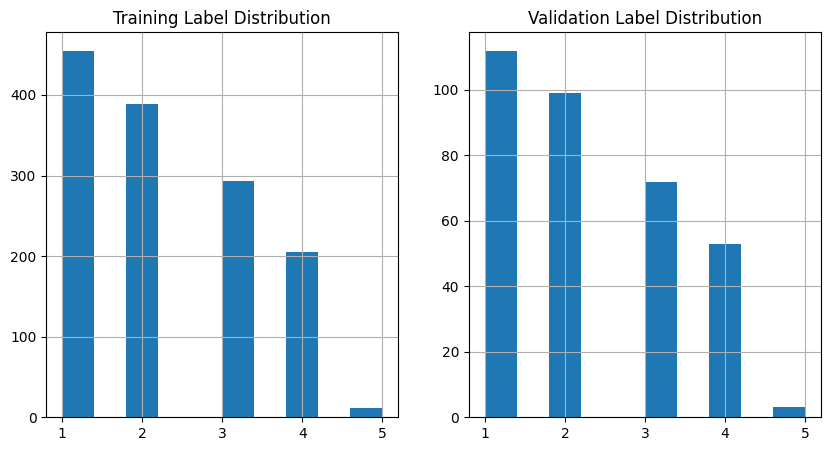

,index,dieSize,failureType,lotName,trainTestLabel,waferIndex,waferMap,failureTypeInt,salientRegion,areaRatio,maxDistFromCenter,minDistFromCenter,perimeterRatio,majorAxisRatio,minorAxisRatio,solidity,eccentricity,yieldLoss,edgeYieldLoss
0,154171,3203.0,Center,lot10006,Training,5.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.0,7.211103,0.0,1.342830,0.409799,0.250052,0.688172,0.792261,0.047444,0.034274
1,155169,1250.0,Center,lot10067,Training,9.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.0,5.000000,0.0,0.639055,0.231693,0.189311,0.684211,0.576529,0.047915,0.090909
2,168248,2393.0,Center,lot10731,Training,9.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.0,2.000000,0.0,0.225222,0.129855,0.059546,1.000000,0.888666,0.015251,0.030120
3,168339,2393.0,Center,lot10742,Training,25.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.0,4.472136,0.0,0.502221,0.230305,0.137377,0.857143,0.802613,0.021190,0.036217
4,169064,2393.0,Center,lot10813,Training,12.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.0,5.099020,0.0,0.559359,0.234194,0.138792,0.888889,0.805471,0.025841,0.040161
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1688,251713,1139.0,Near-full,lot15621,Training,25.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",5,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.0,33.241540,0.0,7.225984,2.036692,1.737496,0.948997,0.521752,0.866667,0.541082
1689,255069,1389.0,Near-full,lot15785,Training,17.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",5,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.0,32.557641,0.0,11.474716,1.716252,1.697205,0.853933,0.148572,0.730793,0.138277
1690,256910,1389.0,Near-full,lot15906,Training,5.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",5,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.0,31.400637,0.0,13.646321,1.738185,1.655185,0.804196,0.305324,0.702081,0.134653
1691,439565,2470.0,Near-full,lot26627,Training,15.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",5,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.0,33.241540,0.0,15.165199,2.014758,1.952000,0.941426,0.247645,0.934357,0.733871


In [21]:
# check train/validation distribution
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
y_train.hist()
plt.title('Training Label Distribution')

plt.subplot(1,2,2)
y_valid.hist()
plt.title('Validation Label Distribution')

plt.show()
df_train

Train and Evaluate a Decision Tree Model

In [22]:
classifier = tree.DecisionTreeClassifier(criterion='log_loss',max_depth=3, random_state=RANDOM_SEED)

classifier = classifier.fit(x_train, y_train)

In [23]:
# Calculates the prediction accuracy.
def calculate_accuracy(pred_labels: np.ndarray, true_labels: np.ndarray):
    accuracy = np.sum(pred_labels == true_labels) / true_labels.__len__() * 100
    return accuracy

# Calculates the prediction acuuracy for each failure type.
def calculate_per_class_accuracy(pred_labels: np.ndarray, true_labels: np.ndarray):
    accuracies = {}
    for i in range(1,6):
        true = 0
        for idx, label in enumerate(true_labels):
            if label == i:
                if pred_labels[idx] == i:
                    true += 1
        accuracy = true/np.sum(true_labels == i)
        accuracies[str(i)] = accuracy*100
    return accuracies

Model accuracy on training data set is 91.88%
Model accuracy on training data set for each class is {'1': 97.36263736263736, '2': 96.1439588688946, '3': 84.30034129692832, '4': 82.92682926829268, '5': 83.33333333333334}%


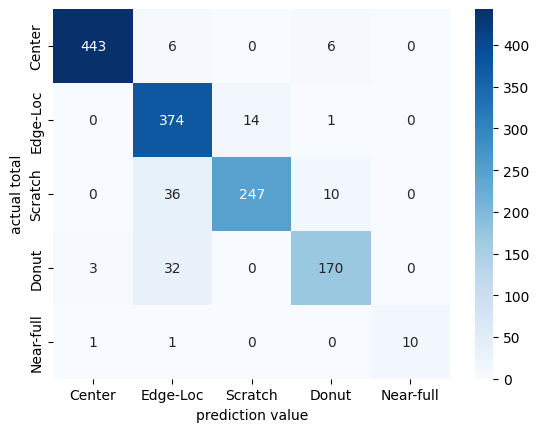

In [29]:
# Get the predicted labels of the training data and calculate the accuracy
pred_train = classifier.predict(x_train)
acc_train = calculate_accuracy(pred_train, y_train)
print(f'Model accuracy on training data set is {acc_train:.2f}%')

# Calculate the accuracy for each failure type
accuracies_train = calculate_per_class_accuracy(pred_train, y_train)
print(f'Model accuracy on training data set for each class is {accuracies_train}%')

# Get failure types string sorted by their numerical value
tick_labels = ["Center", "Edge-Loc", "Scratch", "Donut", "Near-full"]

# Compute confusion matrix and assign labels parameter
cm = confusion_matrix(y_train, pred_train, labels=[1, 2, 3, 4, 5])

# plot confusion matrix using heatmap
sns.heatmap(cm, annot=True, fmt='d', 
            xticklabels=tick_labels , 
            yticklabels=tick_labels,
            cmap='Blues')

plt.xlabel('prediction value')
plt.ylabel('actual total')

# show plot
plt.show()

Model accuracy on validation data set is 87.91%
Model accuracy on validation data set for each class is {'1': 96.42857142857143, '2': 93.93939393939394, '3': 81.94444444444444, '4': 66.0377358490566, '5': 100.0}%


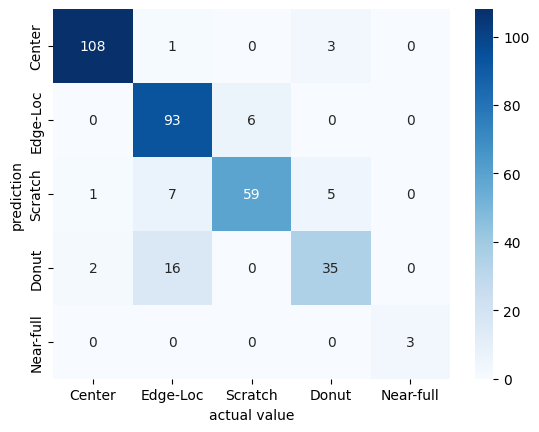

In [30]:
# Get the predicted labels of the validation data and calculate the accuracy
pred_valid = classifier.predict(x_valid)
acc_valid = calculate_accuracy(pred_valid, y_valid)
print(f'Model accuracy on validation data set is {acc_valid:.2f}%')

# Calculate the accuracy for each failure type
accuracies_valid = calculate_per_class_accuracy(pred_valid, y_valid)
print(f'Model accuracy on validation data set for each class is {accuracies_valid}%')

# Get failure types string sorted by their numerical value
tick_labels = ["Center", "Edge-Loc", "Scratch", "Donut", "Near-full"]

# TODO: compute confusion matrix and assign labels parameter
cm = confusion_matrix(y_valid, pred_valid, labels=[1, 2, 3, 4, 5])

# plot confusion matrix using heatmap
sns.heatmap(cm, annot=True, fmt='d', 
            xticklabels=tick_labels, 
            yticklabels=tick_labels,
            cmap='Blues')

plt.xlabel('actual value')
plt.ylabel('prediction')

# show plot
plt.show()

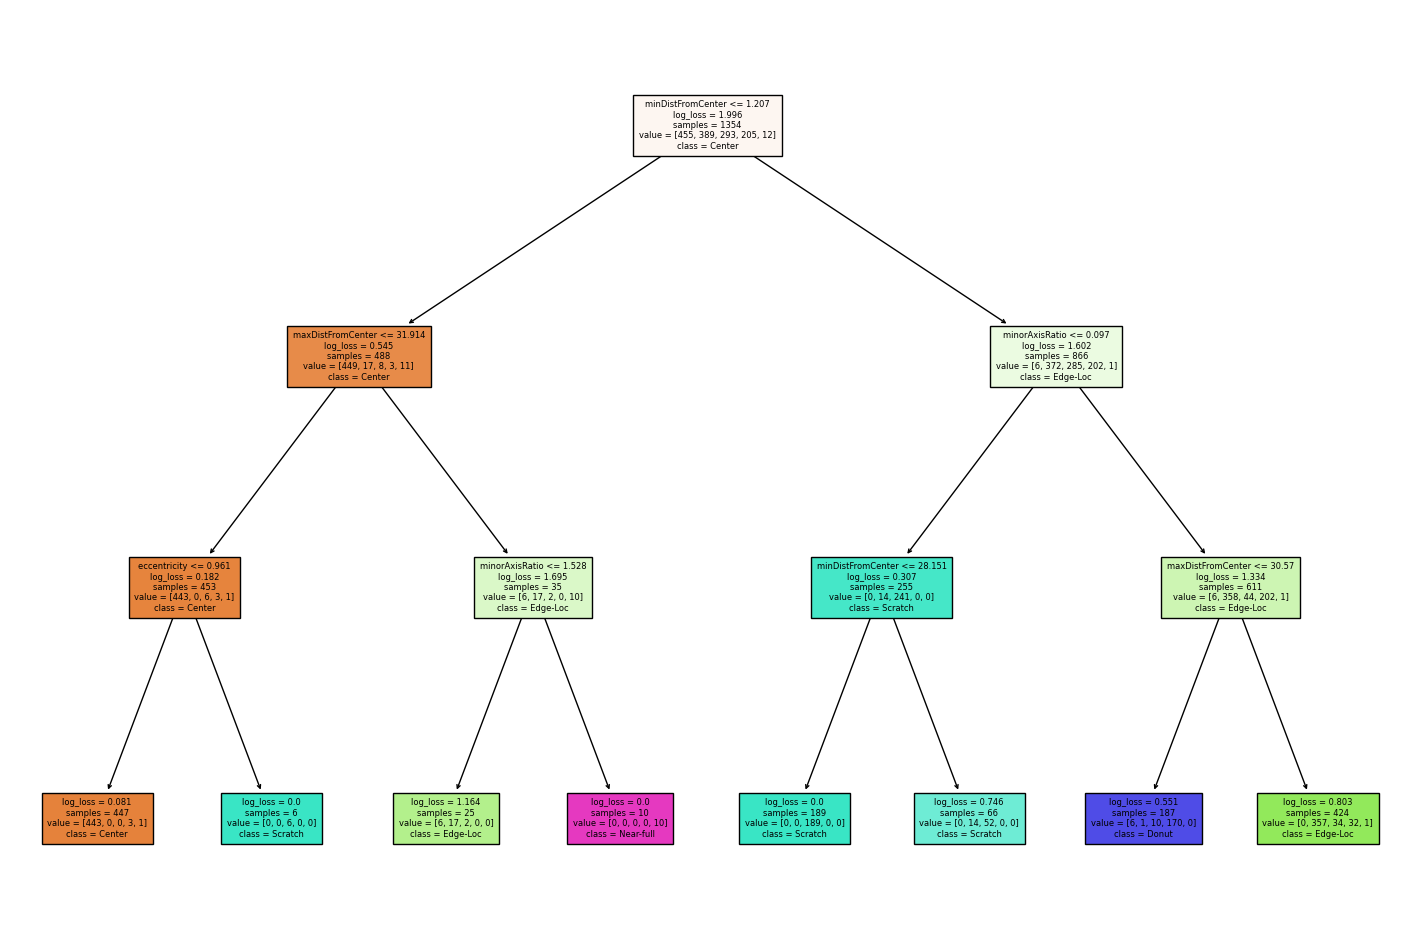

In [31]:
class_names = tick_labels

# plot decision tree
plt.figure(figsize=(18,12))
tree.plot_tree(classifier,                              # classifier to extract the rules from
                feature_names=selected_features,        # the feature names that were used
                class_names=class_names,                # the class labels, converted to string
                filled=True, fontsize=6)
plt.show()

### Testing Set

Data Loading, Preprocess, and Feature Extraction

In [32]:
# Load test dataset with pandas from wafermap_test.npy
np_test = np.load('wafermap_test.npy', allow_pickle=True)
df_test = pd.DataFrame.from_records(np_test)

# Apply data preparation function
df_test['waferMap'] = df_test['waferMap'].apply(resize_wafer_map)

# Apply feature exatractors to extract features
df_test = create_feature_columns(df_test)

Generate Predictions for the Test Set

In [33]:
selected_features = ['areaRatio',
                     'maxDistFromCenter', 'minDistFromCenter', 'perimeterRatio',
                     'majorAxisRatio', 'minorAxisRatio', 'solidity', 'eccentricity',
                     'yieldLoss', 'edgeYieldLoss']
x = df_test[selected_features]
y_predictions = classifier.predict(x)

# Get the predicted labels of the test data and convert them back to string
# and output as scores.csv
def convert_failure(failure_type: int) -> str:
    # Create dictionary for converting string to numeric number
    int2str = {
        1: "Center",
        2: "Edge-Loc",
        3: "Scratch",
        4: "Donut",
        5: "Near-full"
    }

    return int2str[failure_type]
y_string = []
for index, pred in enumerate(y_predictions):
    y_string.append(convert_failure(pred))
pd.Series(y_string,name='failureType').to_csv('scores.csv',index=False)